# Dimensionality reduction

In general a multi-variate regression model (not necessarily linear) could be expressed as looking for a functional dependence 
$$
y=f(x)
$$
between an output variable $y$ and the multi-dimensional vector of input variables (features, regressors) $x=(x_1,x_2,x_3,....,x_n)$.

When the dimensionality $n$ of the feature space (number of regressors) is too high with respect to the number of observations, it may cause multiple issues:

- complexity: the model involving multiple regressors becomes difficult to fit and interpret;

- multicollinearity: a large set of regressors could encounter substantial correlations, leading to multicollinearity of regressors and high variance in their estimates, making coefficients hard to interpret/rely on;

- overfitting: as multiple regressors might contain a lot of relevant but also irrelevant information, the model could pick it up, becoming too specifically adjusted to the training set, which would reduce its generalizeability (performance over the validation/test set);

In addition, exploratory analysis, including visualization of multi-dimensional data is much more difficult. Imagine we want to visualize complaining profiles of NYC neighborhoods? As each profile is characterized with a 162-dimensional vector, how to perform such a visualization? Would not it be more convenient to find a 2D or 3D visual representation instead?

Reducing complexity of the model and its data (number of features or their dimensionality) is usually recommended in such cases. The most streighforward way of doing so is through feature selection. 

Feature selection aims to reduce dimensionality of $x$ by removing some of its components $x_j$ which turn out to be the least relevant for the model, i.e. have the lowest positive or even negative impact on the model performance over the external validation set. This way feature selection provides a mapping of vectors $x$ into a shorter vector of its subcomponents, e.g.
$$
(x_1,x_2,x_3,x_4,x_5)\to (x_1,x_3,x_5).
$$

But feature selection is often too rigid - we have to make our choices of keeping or getting rid of each variable entirely, though it might be the case that each regressor by itself still contains certain valuable information, but all together the feature space is redundant. As an alternative one can think of expressing the useful information contained in a large inital amount of regressors through some smaller amount of latent variables (different from the initial regressors) able to explain all or almost all the relevant information. This is called dimensionality reduction.

In general, dimensionality reduction looks for an arbitrary mapping of the feature space (possibly transforming the features not just removing some) into a new feature space of a smaller dimension:
$$
x=(x_1,x_2,x_3....,x_n)\to x'=(x_1',x_2',x_3',....,x_m),
$$
so that a simpler model $y=f(x')$ could be learned instead.

E.g. a mapping
$$
(x_1,x_2,x_3,x_4,x_5)\to x'=(x_1+x_2+x_3+x_4+x_5,x_1 x_2 x_3 x_4 x_5)
$$
could serve as an example of reducing the dimensionality of the feature space from $5$ to $2$.

Such reduction often turnes out to be pretty useful as learning a model over a smaller set of features could be easier and such models might be more resilient to overfitting and easier to interpret. Often dimensionality could be substantially reduced without reducing the capacity of the model to fit the output variable much. This is becasue the Pareto rule is perfectly applicable in this scenario - 80% (or even 90, 95, 99%) of the useful information contained in the original regressors could be effectively packed into a much smaller amount of the new regressors (under a suitable transformation), often being 20% (or even 10, 5, 1%) of the original size. This way 80% (or even 90, 95, 99%) of the efficieny could be acheived with 20% (or even 10, 5, 1%) of the effort (complexity).

# Problem example

Model economic characteristics of urban neighborhoods (zip code areas), such as  
**income, unemployment or average real estate prices using the structure of 311 complains**  
as a signature of social activity.

[Wang L, Qian C, Kats P, Kontokosta C, Sobolevsky, S. (2017) Structure of 311
service requests as a signature of urban location. PloS ONE. 12(10), e0186314.]

<img src="data/fig5.png">

<img src="data/fig2.png">

We saw that complaining patterns cluster in space but are pretty different for different urban neighborhoods. While the clusters with distinctive complaining profiles are also distinctive in terms of demography and economic background.

**What is we use the relative frequency of each of the 162 categories of complains as features to model target economic indicators accross NYC zip code areas?**

What issues such a model might face?

#### 311 service requests data.
https://en.wikipedia.org/wiki/3-1-1

3-1-1 is a special telephone number supported in many communities in Canada and the United States. The number provides access to non-emergency municipal services. The number format follows the N11 code for a group of short, special-purpose local numbers as designated in the North American Numbering Plan.
The number 3-1-1 is intended in part to divert routine inquiries and non-urgent community concerns from the 9-1-1 number which is reserved for emergency service. A promotional website for 3-1-1 in Akron described the distinction as follows: "Burning building? Call 9-1-1. Burning Question? Call 3-1-1."

But first let's ask a simpler question - **how can we visualize urban neighborhoods according to the structure of their 311 service requests**?

And can we recognize different boroughs in this visualization?

So how do we visualize 162 dimensional data for each of the approximately 264 zip codes?

In [1]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load and curate 311 data

In [2]:
data311 = pd.read_csv( 'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [3]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [4]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [5]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [6]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [7]:
list_311=list(data311.columns)

In [8]:
list_311[0:10]

['APPLIANCE',
 'Adopt-A-Basket',
 'Air Quality',
 'Animal Abuse',
 'Animal Facility - No Permit',
 'Animal in a Park',
 'Asbestos',
 'BEST/Site Safety',
 'Beach/Pool/Sauna Complaint',
 'Bike Rack Condition']

In [9]:
len(data311)

264

In [10]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [11]:
len(data311) #only 179 zip codes with reliable data left

179

In [12]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


In [13]:
# create borough labels 
Z=np.array(data311.index)
manhattanInd=(Z>10000)&(Z<10300) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
#create an array of the same length as data311 index providing the borough number
D=Z*0
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

Try visualizing the data based on some two types of complaints

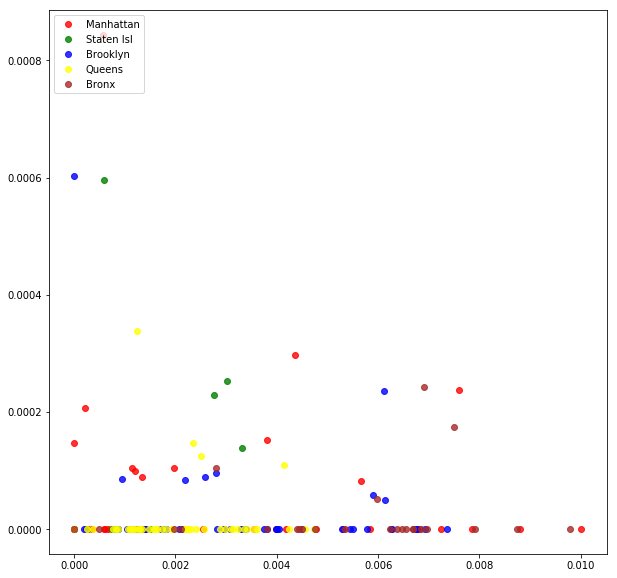

In [14]:
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311.iloc[D==d,0]), np.array(data311.iloc[D==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')

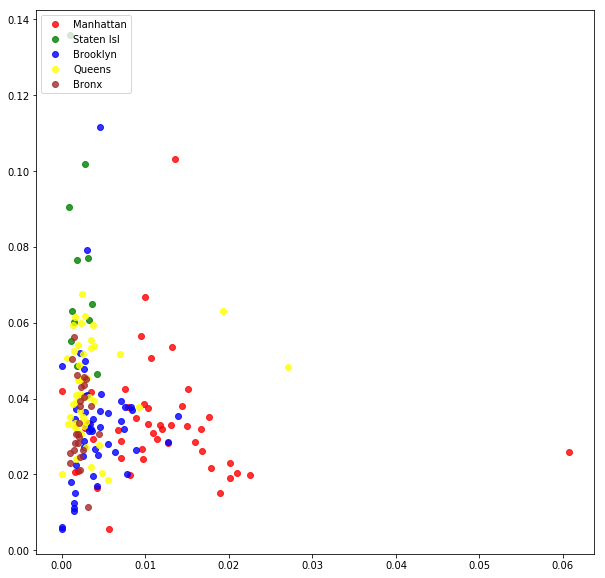

In [15]:
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311.loc[D==d,'Air Quality']), np.array(data311.loc[D==d,'Water System']),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')

#### So is it possible to find a smaller number of parameters to adequately represent high dimensional data?

### Example 1. Toy data

In [16]:
#generate a random sample of houses with "Size" and "Price" being function of it
np.random.seed(1)
N=100
S=np.random.randint(1000,10000, size=N)
P=S*300+50000
data1 = pd.DataFrame({'S':S,'P':P})
data1.head()

,P,S
0,420500,1235
1,1907600,6192
2,621500,1905
3,2693900,8813
4,1218500,3895


Text(0,0.5,'P')

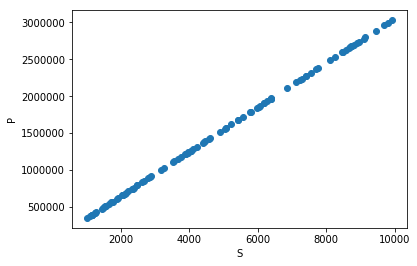

In [17]:
#visualize the data
plt.plot(data1.S, data1.P, 'o')
plt.xlabel('S')
plt.ylabel('P')

In [18]:
#all the data points lay on a single line and one can represent all the information by a single-dimensional 
# position coordinate on this line

Text(0,0.5,'P')

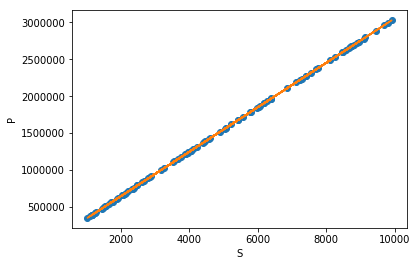

In [19]:
plt.plot(data1.S, data1.P, 'o')
plt.plot(data1.S, data1.P)
plt.xlabel('S')
plt.ylabel('P')

In [20]:
#what if the data is a little more complicated
P=S*300+50000+np.random.normal(0,100000,size=N)
data2 = pd.DataFrame({'S':S,'P':P})
data2.head()

,P,S
0,6.390575e+05,1235
1,1.767950e+06,6192
2,4.770886e+05,1905
3,2.643453e+06,8813
4,1.234504e+06,3895


Text(0,0.5,'P')

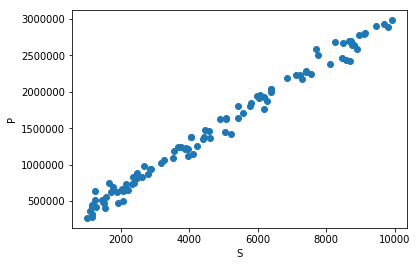

In [21]:
#visualize the data
plt.plot(data2.S, data2.P, 'o')
plt.xlabel('S')
plt.ylabel('P')

In [22]:
#there is high correlation in data
data2.corr()

,P,S
P,1.0000,0.9942
S,0.9942,1.0000


In [23]:
#standardize the data
data2S=(data2-data2.mean())/data2.std()

Text(0,0.5,'P')

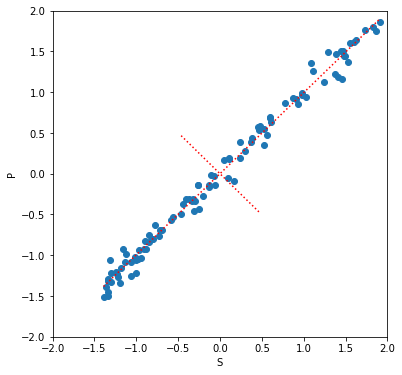

In [24]:
#The data is still largely around one major line
#but there is also some fluctuation in the orthogonal dymension
plt.figure(figsize=(6,6))
plt.plot(data2S.S, data2S.P, 'o')
x=data2S.S.sort_values()
plt.plot(x, x*np.corrcoef(data2S.S,data2S.P)[0,1],':r')
x=data2S.S[abs(data2S.S)<0.5].sort_values()
plt.plot(x, -x/np.corrcoef(data2S.S,data2S.P)[0,1],':r')
plt.xlim((-2,2)); plt.ylim((-2,2));
plt.xlabel('S')
plt.ylabel('P')

Those two dashed lines form axis of a new coordinate system in which the first coordiate largely represents the data, while second containts some residual variation. Note that the first axis is picked in such a way that **variance of the data along it is maximized**

How to convert them to uncorrelated features $p_1$,$p_2$ (principal components) using some linear transform 
$$
P=XV?
$$ 

$P$ is a matrix of two columns $p_1$,$p_2$, while $V$ is a $2x2$ conversion matrix.

This transform will effectively rotate the image above to get a cloud with approximate axial symmetry. Or we can think of it as selecting different coordinate axis, so that X being projected on them (represented in a new system of coordinates) is expressed by $P$.

In [25]:
#find eigenvectors of X'X
XS=np.array(data2S)
XC=np.dot(XS.transpose(),XS)
eigvalues, eigvectors = np.linalg.eig(XC)
print 'Eigenvalues=',eigvalues
print 'Eigenvectors=\n',eigvectors

Eigenvalues= [197.42576011   0.57423989]
Eigenvectors=
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [26]:
#make sure eigenvalues are sorted and form the matrix of eigenvectors
idx = eigvalues.argsort()[::-1]   
eigvalues = eigvalues[idx]
eigvectors = eigvectors[:,idx]
V = eigvectors
V

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [27]:
#perform the transformation computing new coordinates for the data in the new coordinate system (principal components)
P=np.dot(XS,V)

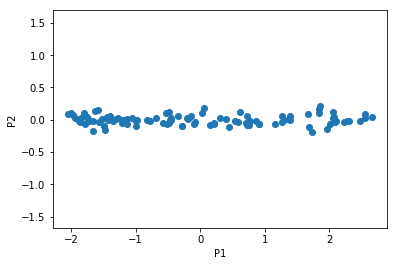

In [28]:
#visualize PCs
plt.plot(P[:,0],P[:,1], 'o')
plt.xlabel('P1')
plt.ylabel('P2')
plt.axis('equal'); #enforce same scale for axes

In [29]:
#check there is no correlation now
np.corrcoef(P[:,0],P[:,1])

array([[1.00000000e+00, 2.33586986e-15],
       [2.33586986e-15, 1.00000000e+00]])

# Principle component analysis

A most common linear approach to dimentionality reduction is the principal component analysis. An idea is that given $N$ observations for the $n$ regressors $x_j$

$$
X=\{x_i^j, i=1..n, j=1..N\}
$$

we try to come up with a linear transformation

$$
U=X V,
$$

where $V$ is $nxp$-dimensional transformation matrix and $U$ is a $N x p$ matrix of new factors $u_1,u_2,...,u_p$ (columns of $U$), such that they explain as much of initial information contained in $X$ as possible for the $p$ latent variables - linear combinations of the original ones.

## Technique

Before applying PCA variables $x_i$ are usually centered ($E[x_i]=0$) and sometimes also normalized ($var[x_i]=1$).

**Selecting first principle component**: look for the column unit basis $N x 1$ vector of weights/loadings $v_1$, such that resulting variable 
$$
u_1=X v_1
$$ 
has maximal possible variance 
$$
var[u_1]\to\max
$$
(captures as much information/distinctions from the complete feature space $X$)

So we maximize
$$
var[u_1]=(X v_1)^T X v_1=v_1^T X^T X v_1\to \max
$$
or
$$
v_1=argmax_{v_1: v_1^T v_1=1}var[u_1] =argmax_{v_1: v_1^T v_1=1}u_1^T u_1=argmax_{v_1: v_1^T v_1=1}v_1^T X^T X v_1.
$$

Then after first basis vector $v_1$ and principle component $u_1$ are selected, the second basis vector $v_2$ is selected following the same principle, but with an additional constrain of being orthogonal to $v_1$. 

Similarly each following $i$-th vector $v_i$ is being defined as
$$
v_i=argmax_{v_i: v_i^T v_i=1, v_i^T v_j=0, j<i}v_i^T X^T X v_i.
$$

The problem is easy to solve knowing the eigenvectors of $X^T X$, i.e. such unit vectors $v_i$ ($v_i^T v_i=1$) that

$$
\lambda_i v_i=X^T X v_i
$$

So for such eigenvectors vectors $v_i$
$$
var[u_i]=v_i^T X^T X v_i = \lambda_i v_i^T v_i = \lambda_i.
$$

This way one can also see that all the eigenvalues of $X^T X$ are positive.

*And out of them the best choice for $v_1$ is the leading eigenvector with the highest eigenvalue.*

**Now consider an arbitrary vector $w$** - not necessarily an eigenvector. If we know $n$ unit eigenvectors with distinct eigenvalues such that $\lambda_1>\lambda_2> ...>\lambda_n>0$, they produce an orthogonal basis in the $n$-dimensional space and for any unit vector $w=e_1 v_1+e_2 v_2+... +e_n v_n$, provided $\sum_i e_i^2=1$, we can see that

$$
w^T X^T X w=\lambda_1 e_1^2+\lambda_2 e_2^2+...+\lambda_n e_n^2,
$$

which is maximized for $e_1=1, e_2=e_3=...e_n=0$ (as $\sum_i e_i^2=1$), *i.e. $w=v_1$*. 

Similarly the second, third, etc loading vectors could be found as $v_2,v_3,...$ correspondingly.

*So the transformation matrix $V$ is composed by the columns being eigenvectors of $X^T X$ and the variance of the data along each of the new axis equals to the value of the corresponding eigenvalue $\lambda_1>\lambda_2> ...>\lambda_n>0$.*

**In the matrix form**

$$
diag(\lambda)V=X^T X V
$$

where $\lambda_i$ are the corresponding eigenvalues (mutually distinctive). First of all its easy to see that such vectors $v_i$ are always mutually orthogonal, as

$$
v_j^T v_i= v_j^T X^T X v_i/\lambda_i =(X^T X w_j)^T v_i/\lambda_i=v_j^T v_i \lambda_j/\lambda_i.
$$

This is why $V^T V=I_n$.

Also the solution follows from the singular value decomposition of the matrix $X$:

$$
X=W \Sigma V^T,
$$

where $W$ is a $N x n$ matrix of mutually orthogonal unit columns, $V$ is a $n x n$ matrix of mutually orthogonal unit columns and $\Sigma$ is an $n x n$- diagonal matrix, i.e.

$$
W^T W=V^T V=I_n
$$

Then

$$
X^T X=V\Sigma W^T W \Sigma V^T=V\Sigma^2 V^T
$$

and its easy to see that $V$ is the matrix of eigenvectors and $\Sigma$ is the diagonal matrix of square roots of eigenvalues. Then 

$$
U=XV=W\Sigma V^T V=W\Sigma.
$$

## PCA as a dimensionality reduction tool

Now once matrixes $V, U, \Sigma$ are defined as well as the eigenvalues $\lambda_j$ (being the squares of the diagonal elements of $\Sigma$), how do we use that for dimensionality reduction? 

Matrix $V$ performs a transformation of the regressors $x_i$ to the new orthogonal variables $u_i$ being the columns of $U=XV$. And 
$$
Var[u_i]=\lambda_i
$$

This is interpreted as each variable $u_i$ containing the fraction $\lambda_i/\sum\limits_j \lambda_j$ of the entire information (variation) contained in all the regressors. And the choice of regressors $u_i$ is such that $\lambda_1,\lambda_2,...$ are sequentially maximized. So if one wants to select as few latent variables as possible in order to cover a given franction $\alpha$ (often $95\%$) of information (variation) from it is enough to select first $k$ principle components $u_1,u_2,...u_k$, so that 

$$
\frac{\sum\limits_{i=1}^k\lambda_i}{\sum\limits_{i=1}^n\lambda_i}\geq \alpha.
$$

## PCA over the features space for dimensionality reduction in the linear regression

The leading principle components contain most of the information from the entire original feature space, and might be suitable to represent the feature space reducing its dimensionality. This however does not guarantee (although usually provides a good chance) that those leading components are indeed the ones most relevant for modeling the output variables, so reducing dimensionality of the regression model by selecting the leading principle components does not always lead to the best outcome. 

In this case, using regular feature selection (e.g. backward step-wise or forward step-wise) could be the best. PCA however will help by ensuring that the features are not interrelated and can be effectively excluded or included one-by-one. This way feature selection after PCA is always more efficient than the feature selection over the original non-transformed feature space. 

This also makes it more reasible (although still not entirely) to rely on the "naive" feature selection based on p-values. While p-values still represent an intrinsic property of the training set, and this way can not guarantee generalizeability, since the standardized principle components are non-correlated/othogonal, a low p-value is a good indicator of the regressor's utility as long as the size/choice of the training data is sufficient to exclude random coincidences.

The most significant downside of using PCA for feature selection is that the remaining selected principle components could be pretty hard to interpret as they often look like arbitrary linear combinations of multiple features.




## Task 1. Apply PCA to 311 data
- Visualize the explained variance as the function of the number of leading components
- Plot zip codes (as dots) represented by their first and second principal components and colored according to their borough; can you distinguish boroughs based on 311 PCs?

In [30]:
scaler311 = preprocessing.StandardScaler().fit(data311)
data311S=scaler311.transform(data311)  

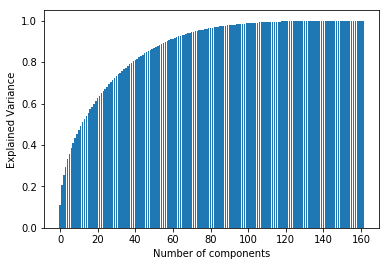

In [51]:
#perform PC decomposition over data311
pca = PCA(data311S.shape[1])
data311P=pca.fit_transform(data311S)
eigenvalues = pca.explained_variance_ratio_
#plot explained variance over the number of compinents
n=data311S.shape[1]
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

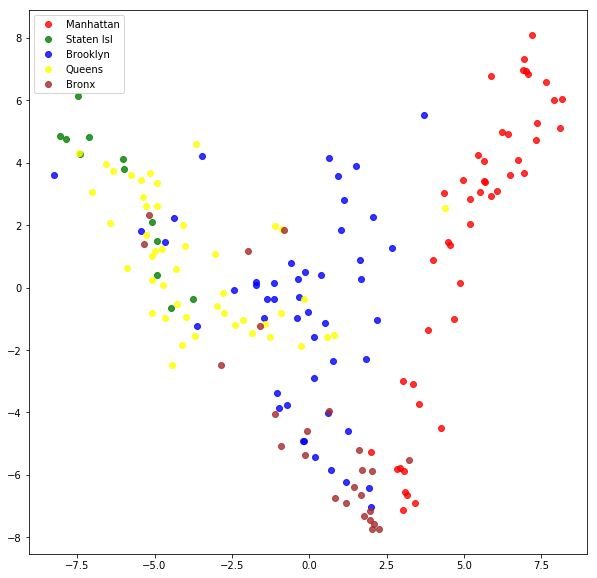

In [48]:
#2-d plot
colors=('gray','red','green','blue','yellow','brown')
fig = plt.figure(figsize=(10,10))
for d in range(1,6):
    plt.plot(np.array(data311P[D==d,0]), np.array(data311P[D==d,1]),
        'o', color=colors[d], alpha=0.8, label=d)
plt.legend(['Manhattan','Staten Isl','Brooklyn','Queens','Bronx'],loc='upper left')

# Principal component regression

## Modeling median income with 311 patterns

In [33]:
#load the data
dataIncome=pd.read_csv("data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [34]:
#merge income data with 311
DataIncome1=dataIncome.merge(data311,left_index=True,right_index=True)

In [35]:
DataIncome1.head()

,Median,Mean,Pop,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10001.0,71244.6100,123112.7764,17678,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,30843.9574,46258.6118,70878,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,89998.5339,139330.9968,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,110183.6857,156682.7615,1271,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0
10005.0,115133.2855,163762.6601,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,...,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.0,0.0


In [36]:
data=DataIncome1.iloc[:,3:]
Y=DataIncome1.Median
lm=sm.OLS(Y,sm.add_constant(data)).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                 Median   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     14.53
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           2.35e-06
Time:                        16:40:54   Log-Likelihood:                -1569.2
No. Observations:                 175   AIC:                             3462.
Df Residuals:                      13   BIC:                             3975.
Df Model:                         161                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [37]:
#however as we see number of observations almost matches the number of regressors (162)
DataIncome1.shape

(175, 165)

In [38]:
np.random.seed(0)
# Apply cross-validation to diagnose model for overfitting
np.random.seed(2018)
R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
n=100 #number of runs
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(sm.add_constant(data.iloc[:,:10]),Y,test_size=0.3) #randomly split data into training (70%) and test (30%)
    res=sm.OLS(y_train,X_train).fit()
    R_IS.append(res.rsquared)   
    y_pred=res.predict(X_test)
    R_OS.append(r2_score(y_test,y_pred))
    
    #R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))

IS R-squared is 0.578+-0.030
OS R-squared is 0.371+-0.138


Severe overfitting encountered, even if we take either half of the variables (making sure regression is not going to be a simple linear model), the pattern is still the same. Feature selection can help but even this does not allow to get above 40% OS R2

In [39]:
np.random.seed(0)
# Apply cross-validation to diagnose model for overfitting
R_IS=[]; R_OS=[] #lists for recording in-sample (training) and out-of-sample (test) R2
n=100 #number of runs
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:],Y,test_size=0.3) #randomly split data into training (70%) and test (30%)
    #now apply PCA to the training data
    scaler = preprocessing.StandardScaler().fit(X_train) #introduce a scaler first as it is important to scale data before PCA!
    pca = PCA(3) #take only 3 leading principal components to get enough data but avoid overfitting
    P_train=pca.fit_transform(scaler.transform(X_train)) #get principal components for the scaled training sample
    res=sm.OLS(y_train,sm.add_constant(P_train)).fit() #fit the regression over 
    #and apply the same scaling and rotation (PCA) transform we learned for training sample to the test sample
    #this is important that we learn scaling and PCA transform from the training sample only rather than from both - training and test
    #as this is part of the principle component regression we need to train; and all training should happen over the training set
    P_test=pca.transform(scaler.transform(X_test))
    y_pred=np.asarray(res.predict(sm.add_constant(P_test)))
    
    R_IS.append(res.rsquared)
    R_OS.append(r2_score(y_test,y_pred))
print("IS R-squared is %.3f+-%.3f"%(np.mean(R_IS),np.std(R_IS)))
print("OS R-squared is %.3f+-%.3f"%(np.mean(R_OS),np.std(R_OS)))

IS R-squared is 0.605+-0.037
OS R-squared is 0.560+-0.098


Out of sample R2 is now 56%! And almost as high ar IS R2, so almost no overfitting

# Task 2. 
a) Repeat the analysis above for Mean income. 

b) Analyze performance depending on the number N of leading PCs to take. 

c) Try implementing Lasso regression (feature selection) over all the PCs instead of selecting the top 5. Manually tune the regularization parameter

d) Now implement cross-validation for Lasso PCA regression above with further splitting the training sample into training and validation and tuning the parameter over the validation sample